In [ ]:
# Initial Imports:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# To run models:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from joblib import dump, load

# For visualizations:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


# Pre-Processing:  
# 3-Factor Model

In [ ]:
# Define function to read in factors from csv and return cleaned dataframe:
def get_factors(factors):
  factor_file=factors+".csv"
  factor_df = pd.read_csv(factor_file)

  # Clean factor dataframe:
  factor_df = factor_df.rename(columns={
    'Unnamed: 0': 'Date',
  })

  factor_df['Date'] = factor_df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

  # Set "Date" as Index:
  factor_df = factor_df.set_index('Date')

  return factor_df

In [ ]:
# Confirm Fama-French dataframe:
factors = get_factors("french_fama")
factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.10,-0.24,-0.28,0.009
1926-07-02,0.45,-0.32,-0.08,0.009
1926-07-06,0.17,0.27,-0.35,0.009
1926-07-07,0.09,-0.59,0.03,0.009
1926-07-08,0.21,-0.36,0.15,0.009


In [ ]:
# Do same thing as above, but for the individual stock CSV:
def choose_stock(ticker):
  ticker_file=ticker+".csv"
  stock=pd.read_csv(ticker_file, index_col='Date', parse_dates=True, infer_datetime_format=True)
  stock["Returns"]=stock["Close"].dropna().pct_change()*100
  stock.index = pd.Series(stock.index).dt.date

  return stock

In [ ]:
# Read in ATT dataframe using above function:
ticker="T"
stock=choose_stock(ticker)
stock.head()

,Close,Returns
Date,,
2000-01-03,47.00,NaN
2000-01-04,44.25,-5.851064
2000-01-05,44.94,1.559322
2000-01-06,43.75,-2.647975
2000-01-07,44.13,0.868571


In [ ]:
# Concatenate Fama-French dataframe with Stock dataframe:
combined_df = pd.concat([factors, stock], axis='columns', join='inner')

# Drop nulls:
combined_df = combined_df.dropna()
combined_df = combined_df.drop('RF', axis=1)

# Preview dataframe:
combined_df.head()

,Mkt-RF,SMB,HML,Close,Returns
Date,,,,,
2000-01-04,-4.06,-0.01,2.14,44.25,-5.851064
2000-01-05,-0.09,0.15,0.29,44.94,1.559322
2000-01-06,-0.73,-0.41,1.27,43.75,-2.647975
2000-01-07,3.21,-0.50,-1.43,44.13,0.868571
2000-01-10,1.76,0.97,-1.52,44.75,1.404940


In [ ]:
# Define X and y variables:
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)
y = combined_df.loc[:, 'Returns']

In [ ]:
# Split into Training/Testing Data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
close_test=combined_df["Close"][split:]
close_test

Date
2016-09-26    41.14
2016-09-27    41.46
2016-09-28    40.85
2016-09-29    40.73
2016-09-30    40.61
              ...  
2020-11-20    28.32
2020-11-23    28.62
2020-11-24    29.23
2020-11-25    28.99
2020-11-27    29.03
Name: Close, Length: 1052, dtype: float64

In [ ]:
# Import Linear Regression Model from SKLearn:
from sklearn.linear_model import LinearRegression

# Create, train, and predict model:
lin_reg_model = LinearRegression(fit_intercept=True)
lin_reg_model = lin_reg_model.fit(X_train, y_train)
predictions = lin_reg_model.predict(X_test)

In [ ]:
# Convert y_test to a dataframe:
y_test = y_test.to_frame()

In [ ]:
signals_df = y_test.copy()

# Add "predictions" to dataframe:
y_test['Predictions'] = predictions
y_test["Close"]=close_test

# Add "Buy Signal" column based on whether day's predictions were greater than the day's actual returns:
y_test['Buy Signal'] = np.where(y_test['Predictions'] > y_test['Returns'], 1.0,0.0)

# Drop nulls:
y_test=y_test.dropna()

y_test.head()

,Returns,Predictions,Close,Buy Signal
Date,,,,
2016-09-26,-0.339147,-0.610985,41.14,0.0
2016-09-27,0.777832,0.490730,41.46,0.0
2016-09-28,-1.471298,0.404347,40.85,1.0
2016-09-29,-0.293758,-0.541782,40.73,0.0
2016-09-30,-0.294623,0.536362,40.61,1.0


In [ ]:
# Define function to generate signals dataframe for algorithm:
def generate_signals(input_df, start_capital=100000, share_count=2000):
  # Set initial capital:
  initial_capital = float(start_capital)

  signals_df = input_df.copy()

  # Set the share size:
  share_size = share_count

  # Take a 500 share position where the Buy Signal is 1 (prior day's predictions greater than prior day's returns):
  signals_df['Position'] = share_size * signals_df['Buy Signal']

  # Make Entry / Exit Column:
  signals_df['Entry/Exit']=signals_df["Buy Signal"].diff()

  # Find the points in time where a 500 share position is bought or sold:
  signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

  # Multiply share price by entry/exit positions and get the cumulative sum:
  signals_df['Portfolio Holdings'] = signals_df['Close'] * signals_df['Entry/Exit Position'].cumsum()

  # Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio:
  signals_df['Portfolio Cash'] = initial_capital - (signals_df['Close'] * signals_df['Entry/Exit Position']).cumsum()

  # Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments):
  signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

  # Calculate the portfolio daily returns:
  signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

  # Calculate the cumulative returns:
  signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

  signals_df = signals_df.dropna()
  
  return signals_df

In [ ]:
# Generate and view signals dataframe using generate signals function
signals_df=generate_signals(y_test)
signals_df.head(10)

,Returns,Predictions,Close,Buy Signal,Position,Entry/Exit,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,
2016-09-28,-1.471298,0.404347,40.85,1.0,2000.0,1.0,2000.0,81700.0,18300.0,100000.0,0.000000,0.0000
2016-09-29,-0.293758,-0.541782,40.73,0.0,0.0,-1.0,-2000.0,0.0,99760.0,99760.0,-0.002400,-0.0024
2016-09-30,-0.294623,0.536362,40.61,1.0,2000.0,1.0,2000.0,81220.0,18540.0,99760.0,0.000000,-0.0024
2016-10-03,0.393992,-0.199927,40.77,0.0,0.0,-1.0,-2000.0,0.0,100080.0,100080.0,0.003208,0.0008
2016-10-04,-2.133922,-0.362826,39.90,1.0,2000.0,1.0,2000.0,79800.0,20280.0,100080.0,0.000000,0.0008
2016-10-05,-1.854637,0.377870,39.16,1.0,2000.0,0.0,0.0,78320.0,20280.0,98600.0,-0.014788,-0.0140
2016-10-06,-0.127681,0.086687,39.11,1.0,2000.0,0.0,0.0,78220.0,20280.0,98500.0,-0.001014,-0.0150
2016-10-07,-0.613654,-0.059479,38.87,1.0,2000.0,0.0,0.0,77740.0,20280.0,98020.0,-0.004873,-0.0198
2016-10-10,0.360175,0.147721,39.01,0.0,0.0,-1.0,-2000.0,0.0,98300.0,98300.0,0.002857,-0.0170


In [ ]:
def algo_evaluation(signals_df):
  # Prepare dataframe for metrics
  metrics = [
      'Annual Return',
      'Cumulative Returns',
      'Annual Volatility',
      'Sharpe Ratio',
      'Sortino Ratio']

  columns = ['Backtest']

  # Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
  portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
  # Calculate cumulative returns:
  portfolio_evaluation_df.loc['Cumulative Returns'] = signals_df['Portfolio Cumulative Returns'][-1]
  # Calculate annualized returns:
  portfolio_evaluation_df.loc['Annual Return'] = (signals_df['Portfolio Daily Returns'].mean() * 252)
  # Calculate annual volatility:
  portfolio_evaluation_df.loc['Annual Volatility'] = (signals_df['Portfolio Daily Returns'].std() * np.sqrt(252))
  # Calculate Sharpe Ratio:
  portfolio_evaluation_df.loc['Sharpe Ratio'] = (signals_df['Portfolio Daily Returns'].mean() * 252) / (signals_df['Portfolio Daily Returns'].std() * np.sqrt(252))

  #Calculate Sortino Ratio/Downside Return:
  sortino_ratio_df = signals_df[['Portfolio Daily Returns']].copy()
  sortino_ratio_df.loc[:,'Downside Returns'] = 0

  target = 0
  mask = sortino_ratio_df['Portfolio Daily Returns'] < target
  sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
  down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
  expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
  sortino_ratio = expected_return/down_stdev

  portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio


  return portfolio_evaluation_df

In [ ]:
# Generate Metrics for Algorithm:
algo_evaluation(signals_df)

,Backtest
Annual Return,0.030028
Cumulative Returns,0.0978
Annual Volatility,0.123528
Sharpe Ratio,0.243087
Sortino Ratio,0.340549


In [ ]:
# Define function to evaluate the underlying asset:
def underlying_evaluation(signals_df):
  underlying=pd.DataFrame()
  underlying["Close"]=signals_df["Close"]
  underlying["Portfolio Daily Returns"]=underlying["Close"].pct_change()
  underlying["Portfolio Daily Returns"].fillna(0,inplace=True)
  underlying['Portfolio Cumulative Returns']=(1 + underlying['Portfolio Daily Returns']).cumprod() - 1

  underlying_evaluation=algo_evaluation(underlying)

  return underlying_evaluation    

In [ ]:
# Define function to return algo evaluation relative to underlying asset combines the two evaluations into a single dataframe
def algo_vs_underlying(signals_df):
  metrics = [
      'Annual Return',
      'Cumulative Returns',
      'Annual Volatility',
      'Sharpe Ratio',
      'Sortino Ratio']

  columns = ['Algo','Underlying']
  algo=algo_evaluation(signals_df)
  underlying=underlying_evaluation(signals_df)

  comparison_df=pd.DataFrame(index=metrics,columns=columns)
  comparison_df['Algo']=algo['Backtest']
  comparison_df['Underlying']=underlying['Backtest']

  return comparison_df

# Generate Metrics for Function vs. Buy-and-Hold Strategy:
algo_vs_underlying(signals_df)

,Algo,Underlying
Annual Return,0.030028,-0.0516554
Cumulative Returns,0.0978,-0.289351
Annual Volatility,0.123528,0.24564
Sharpe Ratio,0.243087,-0.210289
Sortino Ratio,0.340549,-0.282077


In [ ]:
# Define function which accepts daily signals dataframe and returns evaluations of individual trades:
def trade_evaluation(signals_df):
  
  #initialize dataframe
  trade_evaluation_df = pd.DataFrame(
    columns=[
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
  )
  
  
  entry_date = ''
  exit_date = ''
  entry_portfolio_holding = 0
  exit_portfolio_holding = 0
  share_size = 0
  entry_share_price = 0
  exit_share_price = 0

  # Loop through signal DataFrame
  # If `Entry/Exit` is 1, set entry trade metrics
  # Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
  # Then append the record to the trade evaluation DataFrame
  for index, row in signals_df.iterrows():
      if row['Entry/Exit'] == 1:
          entry_date = index
          entry_portfolio_holding = row['Portfolio Total']
          share_size = row['Entry/Exit Position']
          entry_share_price = row['Close']

      elif row['Entry/Exit'] == -1:
          exit_date = index
          exit_portfolio_holding = abs(row['Portfolio Total'])
          exit_share_price = row['Close']
          profit_loss = exit_portfolio_holding - entry_portfolio_holding
          trade_evaluation_df = trade_evaluation_df.append(
              {
                  'Entry Date': entry_date,
                  'Exit Date': exit_date,
                  'Shares': share_size,
                  'Entry Share Price': entry_share_price,
                  'Exit Share Price': exit_share_price,
                  'Entry Portfolio Holding': entry_portfolio_holding,
                  'Exit Portfolio Holding': exit_portfolio_holding,
                  'Profit/Loss': profit_loss
              },
              ignore_index=True)

  # Print the DataFrame
  return trade_evaluation_df

In [ ]:
# Generate Evaluation table:
trade_evaluation_df=trade_evaluation(signals_df)
trade_evaluation_df

,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,2016-09-28,2016-09-29,2000.0,40.85,40.73,100000.0,99760.0,-240.0
1,2016-09-30,2016-10-03,2000.0,40.61,40.77,99760.0,100080.0,320.0
2,2016-10-04,2016-10-10,2000.0,39.90,39.01,100080.0,98300.0,-1780.0
3,2016-10-14,2016-10-17,2000.0,39.22,39.27,98300.0,98400.0,100.0
4,2016-10-18,2016-10-27,2000.0,39.36,36.52,98400.0,92720.0,-5680.0
...,...,...,...,...,...,...,...,...
270,2020-11-06,2020-11-09,2000.0,27.44,28.30,108100.0,109820.0,1720.0
271,2020-11-11,2020-11-13,2000.0,28.73,28.91,109820.0,110180.0,360.0
272,2020-11-16,2020-11-17,2000.0,28.97,29.03,110180.0,110300.0,120.0
273,2020-11-18,2020-11-20,2000.0,28.62,28.32,110300.0,109700.0,-600.0


# ANOVA Table / Other Visualizations for 3-Factor Models:  
# ATT:

In [ ]:
# Set X and y variables:
y = combined_df.loc[:, 'Returns']
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)

# Add "Constant" column of "1s" to DataFrame to act as an intercept, using StatsModels:
X = sm.add_constant(X)

# Split into Training/Testing data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Run Ordinary Least Squares (OLS )Model:
model = sm.OLS(y_test, X_test)
model_results = model.fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     294.6
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          1.19e-138
Time:                        02:04:54   Log-Likelihood:                -1629.4
No. Observations:                1052   AIC:                             3267.
Df Residuals:                    1048   BIC:                             3287.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0495      0.035     -1.404      0.1

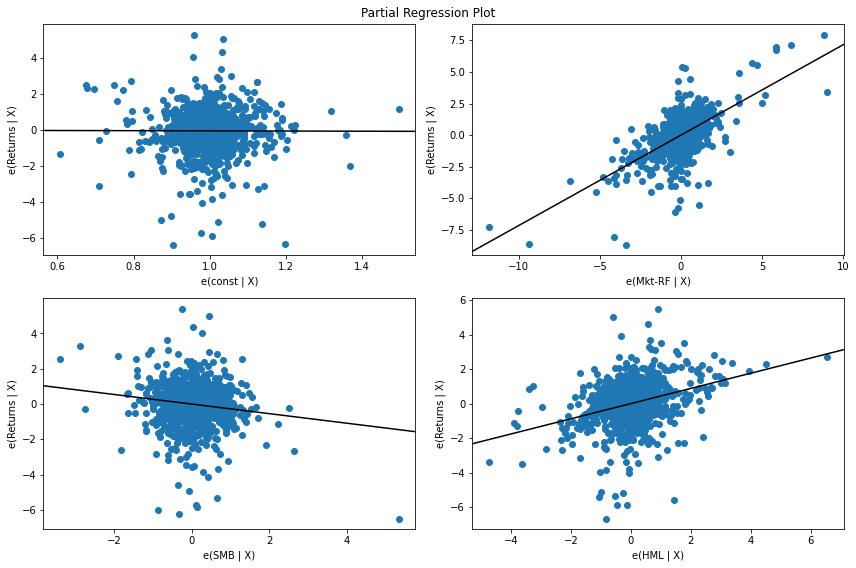

In [ ]:
# Plot Partial Regression Plot:
fig = sm.graphics.plot_partregress_grid(model_results, fig = plt.figure(figsize=(12,8)))
plt.show()

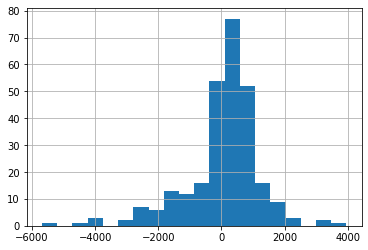

In [ ]:
# Plot P&L Histrogram:
trade_evaluation_df["Profit/Loss"].hist(bins=20)

In [ ]:
# Define function that plots Algo Cumulative Returns vs. Underlying Cumulative Returns:
def underlying_returns(signals_df):
  underlying=pd.DataFrame()
  underlying["Close"]=signals_df["Close"]
  underlying["Underlying Daily Returns"]=underlying["Close"].pct_change()
  underlying["Underlying Daily Returns"].fillna(0,inplace=True)
  underlying['Underlying Cumulative Returns']=(1 + underlying['Underlying Daily Returns']).cumprod() - 1
  underlying['Algo Cumulative Returns']=signals_df["Portfolio Cumulative Returns"]

  graph_df=underlying[["Underlying Cumulative Returns", "Algo Cumulative Returns"]]

  return graph_df

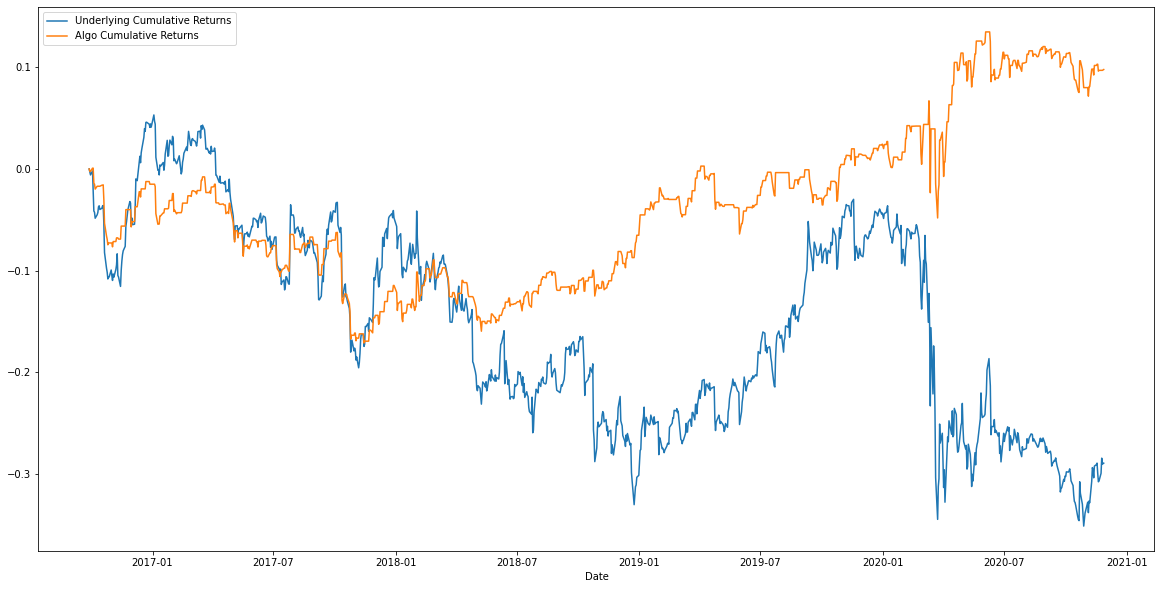

In [ ]:
# Generate Cumulative Return plot using above defined function:
underlying_returns(signals_df).plot(figsize=(20,10))

# DIS:

In [ ]:
# Use pre-defined function to read in $DIS data:
ticker="DIS"
stock=choose_stock(ticker)
stock.head()

,Close,Returns
Date,,
2000-01-03,29.88,NaN
2000-01-04,31.63,5.856760
2000-01-05,32.94,4.141638
2000-01-06,31.94,-3.035823
2000-01-07,31.19,-2.348153


In [ ]:
# Concatenate Fama-French DataFrame with Stock DataFrame:
combined_df = pd.concat([factors, stock], axis='columns', join='inner')

# Drop nulls:
combined_df = combined_df.dropna()
combined_df = combined_df.drop('RF', axis=1)

# Preview DataFrame
combined_df.head()

,Mkt-RF,SMB,HML,Close,Returns
Date,,,,,
2000-01-04,-4.06,-0.01,2.14,31.63,5.856760
2000-01-05,-0.09,0.15,0.29,32.94,4.141638
2000-01-06,-0.73,-0.41,1.27,31.94,-3.035823
2000-01-07,3.21,-0.50,-1.43,31.19,-2.348153
2000-01-10,1.76,0.97,-1.52,35.94,15.229240


In [ ]:
# Define X and y variables:
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)
y = combined_df.loc[:, 'Returns']

In [ ]:
# Split into Training/Testing Data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
close_test=combined_df["Close"][split:]
close_test

Date
2016-09-26     91.96
2016-09-27     91.72
2016-09-28     92.20
2016-09-29     91.80
2016-09-30     92.86
               ...  
2020-11-23    145.98
2020-11-24    151.49
2020-11-25    149.09
2020-11-27    147.13
2020-11-30    148.01
Name: Close, Length: 1053, dtype: float64

In [ ]:
# Import Linear Regression Model from SKLearn:
from sklearn.linear_model import LinearRegression

# Create, train, and predict model:
lin_reg_model = LinearRegression(fit_intercept=True)
lin_reg_model = lin_reg_model.fit(X_train, y_train)
predictions = lin_reg_model.predict(X_test)

In [ ]:
# Convert y_test to a dataframe:
y_test = y_test.to_frame()

In [ ]:
signals_df = y_test.copy()

# Add "predictions" to dataframe:
y_test['Predictions'] = predictions
y_test["Close"]=close_test

# Add "Buy Signal" column based on whether day's predictions were greater than the day's actual returns:
y_test['Buy Signal'] = np.where(y_test['Predictions'] > y_test['Returns'], 1.0,0.0)

# Drop nulls:
y_test=y_test.dropna()

y_test.head()

,Returns,Predictions,Close,Buy Signal
Date,,,,
2016-09-26,-1.404524,-0.895075,91.96,1.0
2016-09-27,-0.260983,0.680834,91.72,1.0
2016-09-28,0.523332,0.658445,92.20,1.0
2016-09-29,-0.433839,-0.907786,91.80,0.0
2016-09-30,1.154684,0.922423,92.86,0.0


In [ ]:
# Generate signals Dataframe using generate signals function
signals_df=generate_signals(y_test)

In [ ]:
# Generate Metrics table for Algorithm:
algo_evaluation(signals_df)

,Backtest
Annual Return,-0.0249067
Cumulative Returns,-0.4162
Annual Volatility,0.4492
Sharpe Ratio,-0.0554467
Sortino Ratio,-0.0739675


In [ ]:
# Generate Metrics table for Algorithm vs. Buy-and-Hold Strategy:
algo_vs_underlying(signals_df)

,Algo,Underlying
Annual Return,-0.0249067,0.153983
Cumulative Returns,-0.4162,0.605315
Annual Volatility,0.4492,0.285475
Sharpe Ratio,-0.0554467,0.539392
Sortino Ratio,-0.0739675,0.814084


In [ ]:
# Generate Metrics table for Disney using pre-defined function:
trade_evaluation_df=trade_evaluation(signals_df)
trade_evaluation_df

,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,,2016-09-29,0,0,91.80,0,100000.0,1.000000e+05
1,2016-10-03,2016-10-04,2000,92.49,92.59,98620,98620.0,0.000000e+00
2,2016-10-05,2016-10-06,2000,92.45,92.83,98900,98900.0,0.000000e+00
3,2016-10-07,2016-10-11,2000,92.49,91.86,99580,99580.0,0.000000e+00
4,2016-10-12,2016-10-13,2000,91.41,91.12,100480,100480.0,0.000000e+00
...,...,...,...,...,...,...,...,...
281,2020-11-02,2020-11-03,2000,120.13,124.02,112540,112540.0,2.910383e-11
282,2020-11-04,2020-11-06,2000,125.07,127.46,110440,110440.0,2.910383e-11
283,2020-11-10,2020-11-13,2000,142.11,138.36,81140,81140.0,0.000000e+00
284,2020-11-19,2020-11-20,2000,141.72,141.07,74420,74420.0,0.000000e+00


In [ ]:
# Set X and y variables:
y = combined_df.loc[:, 'Returns']
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)

# Add "Constant" column of "1s" to DataFrame to act as an intercept, using StatsModels:
X = sm.add_constant(X)

# Split into Training/Testing data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Run Ordinary Least Squares (OLS )Model:
model = sm.OLS(y_test, X_test)
model_results = model.fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     367.5
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          4.54e-163
Time:                        02:04:58   Log-Likelihood:                -1732.8
No. Observations:                1053   AIC:                             3474.
Df Residuals:                    1049   BIC:                             3493.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0186      0.039      0.479      0.6

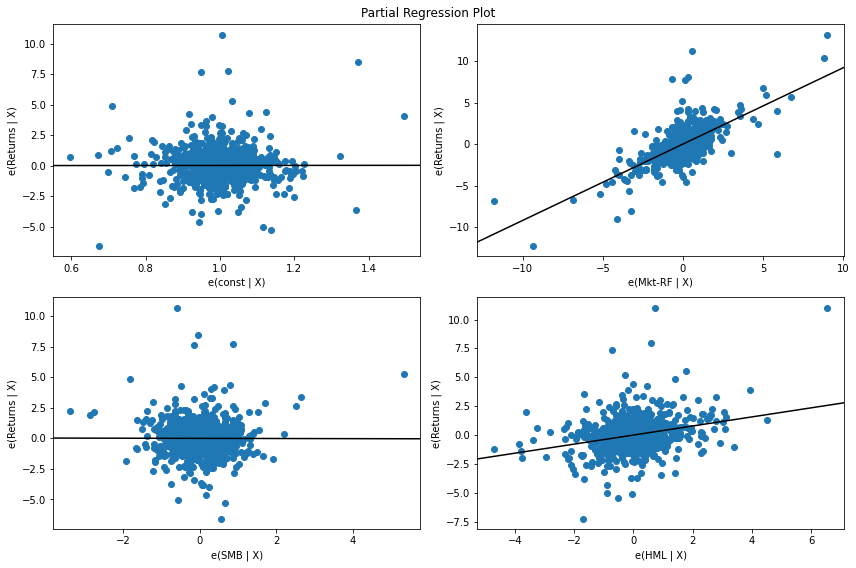

In [ ]:
# Plot Partial Regression Plot:
fig = sm.graphics.plot_partregress_grid(model_results, fig = plt.figure(figsize=(12,8)))
plt.show()

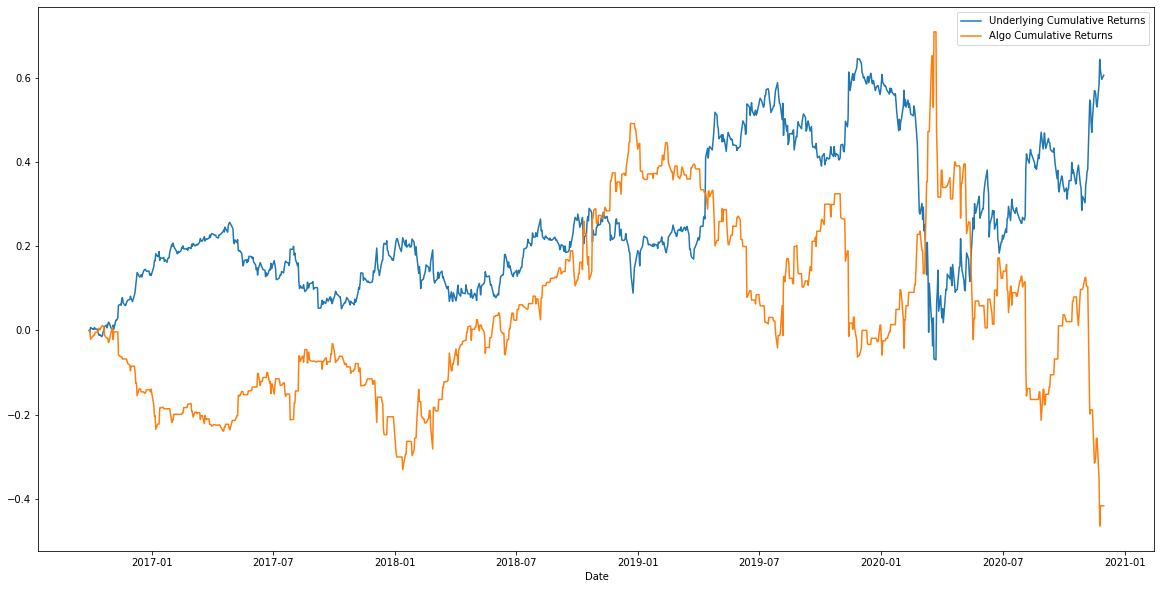

In [ ]:
# Plot Cumulative Returns:
underlying_returns(signals_df).plot(figsize=(20,10))

## SPY

In [ ]:
# Read in SPY data:
ticker="SPY"
stock=choose_stock(ticker)
stock.head()

,Close,Returns
Date,,
2000-01-03,145.44,NaN
2000-01-04,139.75,-3.912266
2000-01-05,140.00,0.178891
2000-01-06,137.75,-1.607143
2000-01-07,145.75,5.807623


In [ ]:
# Concatenate Fama-French DataFrame with Stock DataFrame:
combined_df = pd.concat([factors, stock], axis='columns', join='inner')

# Drop nulls:
combined_df = combined_df.dropna()
combined_df = combined_df.drop('RF', axis=1)

# Preview DataFrame
combined_df.head()

,Mkt-RF,SMB,HML,Close,Returns
Date,,,,,
2000-01-04,-4.06,-0.01,2.14,139.75,-3.912266
2000-01-05,-0.09,0.15,0.29,140.00,0.178891
2000-01-06,-0.73,-0.41,1.27,137.75,-1.607143
2000-01-07,3.21,-0.50,-1.43,145.75,5.807623
2000-01-10,1.76,0.97,-1.52,146.25,0.343053


In [ ]:
# Define X and y variables:
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)
y = combined_df.loc[:, 'Returns']

In [ ]:
# Split into Training/Testing Data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
close_test=combined_df["Close"][split:]
close_test

Date
2016-09-26    214.24
2016-09-27    215.57
2016-09-28    216.64
2016-09-29    214.68
2016-09-30    216.30
               ...  
2020-11-23    357.46
2020-11-24    363.22
2020-11-25    362.66
2020-11-27    363.67
2020-11-30    362.06
Name: Close, Length: 1053, dtype: float64

In [ ]:
# Import Linear Regression Model from SKLearn:
from sklearn.linear_model import LinearRegression

# Create, train, and predict model:
lin_reg_model = LinearRegression(fit_intercept=True)
lin_reg_model = lin_reg_model.fit(X_train, y_train)
predictions = lin_reg_model.predict(X_test)

In [ ]:
# Convert y_test to a dataframe:
y_test = y_test.to_frame()

In [ ]:
signals_df = y_test.copy()

# Add "predictions" to dataframe:
y_test['Predictions'] = predictions
y_test["Close"]=close_test

# Add "Buy Signal" column based on whether day's predictions were greater than the day's actual returns:
y_test['Buy Signal'] = np.where(y_test['Predictions'] > y_test['Returns'], 1.0,0.0)

# Drop nulls:
y_test=y_test.dropna()

y_test.head()

,Returns,Predictions,Close,Buy Signal
Date,,,,
2016-09-26,-0.810223,-0.827255,214.24,0.0
2016-09-27,0.620799,0.641147,215.57,1.0
2016-09-28,0.496358,0.509999,216.64,1.0
2016-09-29,-0.904727,-0.894889,214.68,1.0
2016-09-30,0.754612,0.800921,216.30,1.0


In [ ]:
# Generate signals Dataframe using generate signals function
signals_df=generate_signals(y_test)

In [ ]:
# Generate Metrics for Algorithm:
algo_evaluation(signals_df)

,Backtest
Annual Return,0.321448
Cumulative Returns,0.5308
Annual Volatility,0.660328
Sharpe Ratio,0.486801
Sortino Ratio,0.69577


In [ ]:
# Generate Metrics for Algorithm vs Buy-and-Hold Strategy:
algo_vs_underlying(signals_df)

,Algo,Underlying
Annual Return,0.321448,0.142886
Cumulative Returns,0.5308,0.671252
Annual Volatility,0.660328,0.197921
Sharpe Ratio,0.486801,0.721934
Sortino Ratio,0.69577,0.986703


In [ ]:
# Generate and view Metrics dataframe:
trade_evaluation_df=trade_evaluation(signals_df)
trade_evaluation_df

,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,,2016-10-03,0,0,215.78,0,100420.0,100420.0
1,2016-10-04,2016-10-06,2000,214.68,215.78,100420,102620.0,2200.0
2,2016-10-07,2016-10-10,2000,215.04,216.16,102620,104860.0,2240.0
3,2016-10-11,2016-10-12,2000,213.43,213.71,104860,105420.0,560.0
4,2016-10-13,2016-10-18,2000,213.01,213.71,105420,106820.0,1400.0
...,...,...,...,...,...,...,...,...
297,2020-10-26,2020-10-30,2000,339.39,326.54,149720,124020.0,-25700.0
298,2020-11-04,2020-11-05,2000,343.54,350.24,124020,137420.0,13400.0
299,2020-11-06,2020-11-09,2000,350.16,354.56,137420,146220.0,8800.0
300,2020-11-11,2020-11-13,2000,356.67,358.10,146220,149080.0,2860.0


In [ ]:
# Set X and y variables:
y = combined_df.loc[:, 'Returns']
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)

# Add "Constant" column of "1s" to DataFrame to act as an intercept, using StatsModels:
X = sm.add_constant(X)

# Split into Training/Testing data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Run Ordinary Least Squares (OLS )Model:
model = sm.OLS(y_test, X_test)
model_results = model.fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 5.068e+04
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        02:05:01   Log-Likelihood:                 898.33
No. Observations:                1053   AIC:                            -1789.
Df Residuals:                    1049   BIC:                            -1769.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0046      0.003     -1.443      0.1

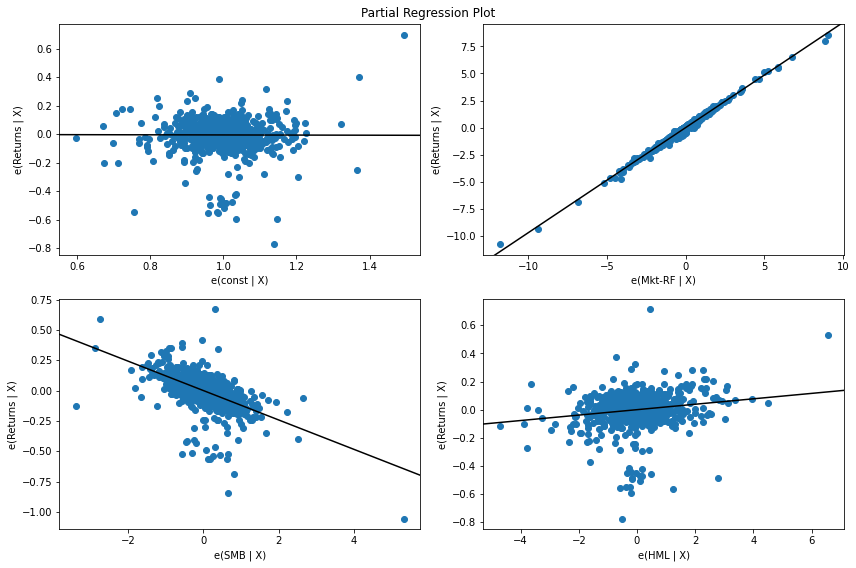

In [ ]:
# Plot Partial Regression Plot:
fig = sm.graphics.plot_partregress_grid(model_results, fig = plt.figure(figsize=(12,8)))
plt.show()

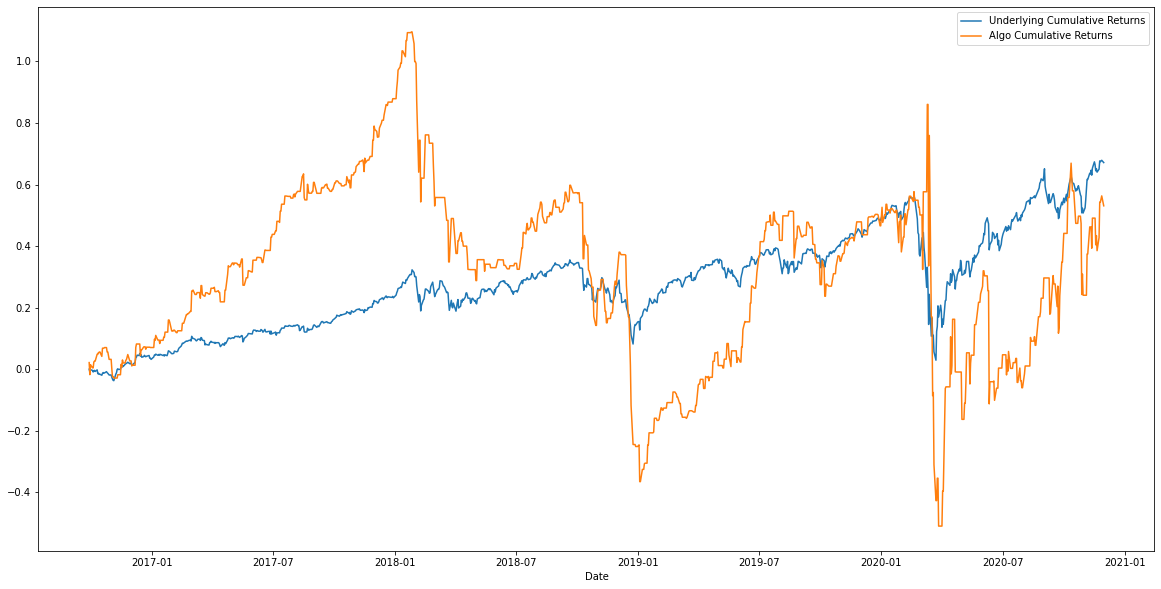

In [ ]:
# Plot Cumulative Returns:
underlying_returns(signals_df).plot(figsize=(20,10))

# Fama-French Five Factor Model:  
# ATT


In [ ]:
# Confirm New Fama-French 5-Factor DataFrame:
factors = get_factors("french_fama_5")
factors.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.67,0.00,-0.32,-0.01,0.15,0.012
1963-07-02,0.79,-0.27,0.27,-0.07,-0.19,0.012
1963-07-03,0.63,-0.17,-0.09,0.17,-0.33,0.012
1963-07-05,0.40,0.08,-0.28,0.08,-0.33,0.012
1963-07-08,-0.63,0.04,-0.18,-0.29,0.13,0.012


In [ ]:
# Read-in ATT dataframe:
ticker="T"
stock=choose_stock(ticker)
stock.head()

,Close,Returns
Date,,
2000-01-03,47.00,NaN
2000-01-04,44.25,-5.851064
2000-01-05,44.94,1.559322
2000-01-06,43.75,-2.647975
2000-01-07,44.13,0.868571


In [ ]:
# Concatenate Fama-French DataFrame with Stock DataFrame:
combined_df = pd.concat([factors, stock], axis='columns', join='inner')

# Drop nulls:
combined_df = combined_df.dropna()
combined_df = combined_df.drop('RF', axis=1)

# Preview DataFrame
combined_df.head()

,Mkt-RF,SMB,HML,RMW,CMA,Close,Returns
Date,,,,,,,
2000-01-04,-4.06,0.35,2.14,0.43,1.46,44.25,-5.851064
2000-01-05,-0.09,0.31,0.29,0.42,1.01,44.94,1.559322
2000-01-06,-0.73,-0.03,1.27,0.65,1.19,43.75,-2.647975
2000-01-07,3.21,-0.95,-1.43,-0.87,-0.95,44.13,0.868571
2000-01-10,1.76,0.50,-1.52,-1.97,-0.07,44.75,1.404940


In [ ]:
# Define X and y variables:
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)
y = combined_df.loc[:, 'Returns']

In [ ]:
# Split into Training/Testing Data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
close_test=combined_df["Close"][split:]
close_test

Date
2016-09-26    41.14
2016-09-27    41.46
2016-09-28    40.85
2016-09-29    40.73
2016-09-30    40.61
              ...  
2020-11-20    28.32
2020-11-23    28.62
2020-11-24    29.23
2020-11-25    28.99
2020-11-27    29.03
Name: Close, Length: 1052, dtype: float64

In [ ]:
# Import Linear Regression Model from SKLearn:
from sklearn.linear_model import LinearRegression

# Create, train, and predict model:
lin_reg_model = LinearRegression(fit_intercept=True)
lin_reg_model = lin_reg_model.fit(X_train, y_train)
predictions = lin_reg_model.predict(X_test)

In [ ]:
# Convert y_test to a dataframe:
y_test = y_test.to_frame()

In [ ]:
signals_df = y_test.copy()

# Add "predictions" to dataframe:
y_test['Predictions'] = predictions
y_test["Close"]=close_test

# Add "Buy Signal" column based on whether day's predictions were greater than the day's actual returns:
y_test['Buy Signal'] = np.where(y_test['Predictions'] > y_test['Returns'], 1.0,0.0)

# Drop nulls:
y_test=y_test.dropna()

y_test.head()

,Returns,Predictions,Close,Buy Signal
Date,,,,
2016-09-26,-0.339147,-0.590607,41.14,0.0
2016-09-27,0.777832,0.361858,41.46,0.0
2016-09-28,-1.471298,0.830449,40.85,1.0
2016-09-29,-0.293758,-0.233493,40.73,1.0
2016-09-30,-0.294623,0.593529,40.61,1.0


In [ ]:
# Generate signals Dataframe using generate signals function
signals_df=generate_signals(y_test)

In [ ]:
# Generate Metrics for Algorithm:
algo_evaluation(signals_df)

,Backtest
Annual Return,0.0233161
Cumulative Returns,0.0688
Annual Volatility,0.12125
Sharpe Ratio,0.192298
Sortino Ratio,0.269316


In [ ]:
# Generate Metrics for Algorithm vs. Buy-and-Hold Strategy: 
algo_vs_underlying(signals_df)

,Algo,Underlying
Annual Return,0.0233161,-0.0516554
Cumulative Returns,0.0688,-0.289351
Annual Volatility,0.12125,0.24564
Sharpe Ratio,0.192298,-0.210289
Sortino Ratio,0.269316,-0.282077


In [ ]:
# Generate and view metrics dataframe:
trade_evaluation_df=trade_evaluation(signals_df)
trade_evaluation_df

,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,2016-09-28,2016-10-03,2000.0,40.85,40.77,100000.0,99840.0,-160.0
1,2016-10-04,2016-10-10,2000.0,39.90,39.01,99840.0,98060.0,-1780.0
2,2016-10-14,2016-10-17,2000.0,39.22,39.27,98060.0,98160.0,100.0
3,2016-10-18,2016-10-27,2000.0,39.36,36.52,98160.0,92480.0,-5680.0
4,2016-11-02,2016-11-03,2000.0,36.37,36.63,92480.0,93000.0,520.0
...,...,...,...,...,...,...,...,...
276,2020-11-03,2020-11-09,2000.0,27.46,28.30,105240.0,106920.0,1680.0
277,2020-11-11,2020-11-13,2000.0,28.73,28.91,106920.0,107280.0,360.0
278,2020-11-16,2020-11-17,2000.0,28.97,29.03,107280.0,107400.0,120.0
279,2020-11-18,2020-11-20,2000.0,28.62,28.32,107400.0,106800.0,-600.0


In [ ]:
# Set X and y variables:
y = combined_df.loc[:, 'Returns']
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)

# Add "Constant" column of "1s" to DataFrame to act as an intercept, using StatsModels:
X = sm.add_constant(X)

# Split into Training/Testing data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Run Ordinary Least Squares (OLS )Model:
model = sm.OLS(y_test, X_test)
model_results = model.fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     187.7
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          1.08e-142
Time:                        02:05:06   Log-Likelihood:                -1614.3
No. Observations:                1052   AIC:                             3241.
Df Residuals:                    1046   BIC:                             3270.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0514      0.035     -1.476      0.1

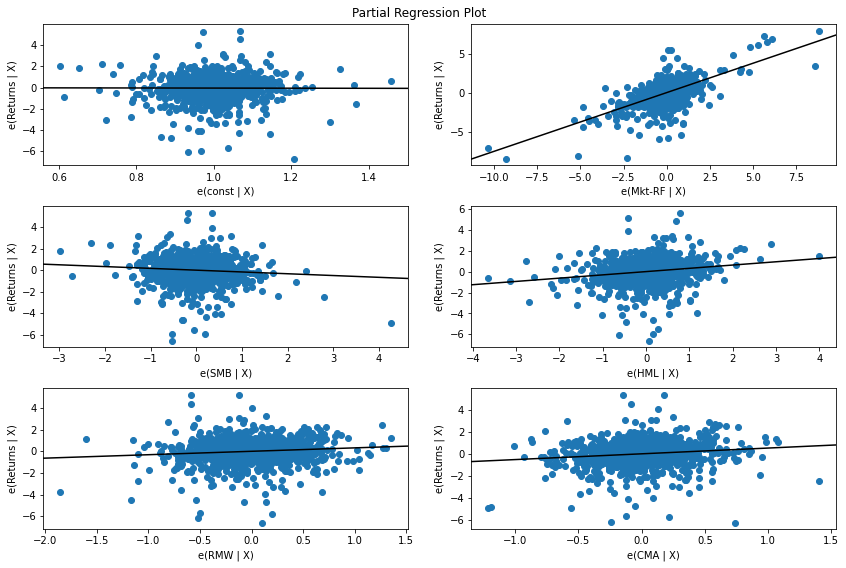

In [ ]:
# Plot Partial Regression Plot:
fig = sm.graphics.plot_partregress_grid(model_results, fig = plt.figure(figsize=(12,8)))
plt.show()

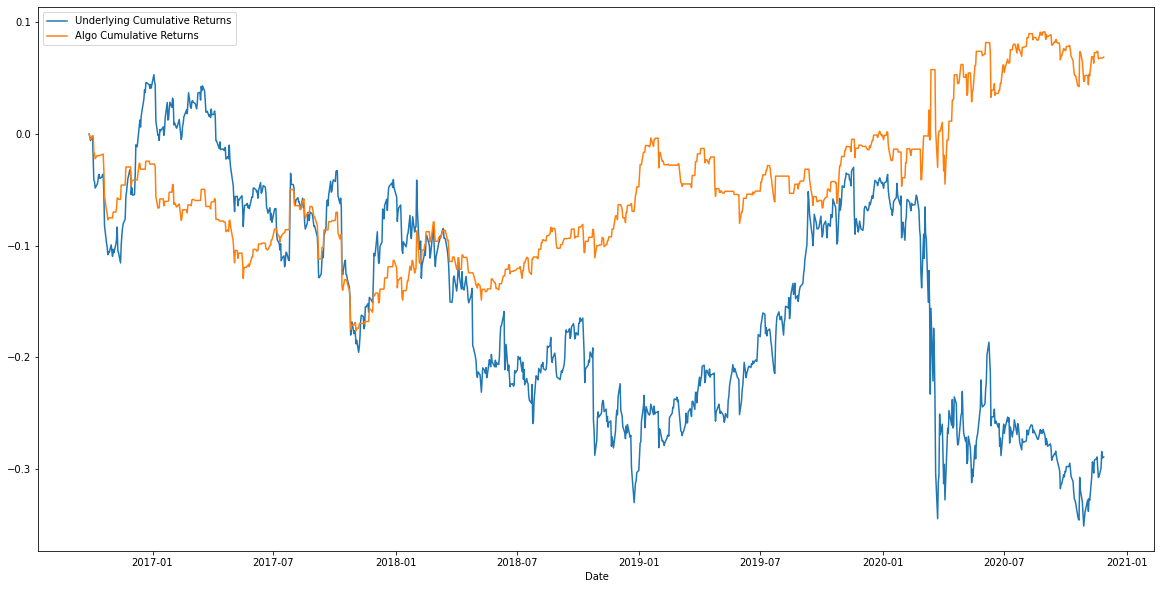

In [ ]:
underlying_returns(signals_df).plot(figsize=(20,10))

## DIS


In [ ]:
# Read-in Disney dataframe:
ticker="DIS"
stock=choose_stock(ticker)
stock.head()

,Close,Returns
Date,,
2000-01-03,29.88,NaN
2000-01-04,31.63,5.856760
2000-01-05,32.94,4.141638
2000-01-06,31.94,-3.035823
2000-01-07,31.19,-2.348153


In [ ]:
# Concatenate Fama-French DataFrame with Stock DataFrame:
combined_df = pd.concat([factors, stock], axis='columns', join='inner')

# Drop nulls:
combined_df = combined_df.dropna()
combined_df = combined_df.drop('RF', axis=1)

# Preview DataFrame
combined_df.head()

,Mkt-RF,SMB,HML,RMW,CMA,Close,Returns
Date,,,,,,,
2000-01-04,-4.06,0.35,2.14,0.43,1.46,31.63,5.856760
2000-01-05,-0.09,0.31,0.29,0.42,1.01,32.94,4.141638
2000-01-06,-0.73,-0.03,1.27,0.65,1.19,31.94,-3.035823
2000-01-07,3.21,-0.95,-1.43,-0.87,-0.95,31.19,-2.348153
2000-01-10,1.76,0.50,-1.52,-1.97,-0.07,35.94,15.229240


In [ ]:
# Define X and y variables:
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)
y = combined_df.loc[:, 'Returns']

In [ ]:
# Split into Training/Testing Data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
close_test=combined_df["Close"][split:]
close_test

Date
2016-09-26     91.96
2016-09-27     91.72
2016-09-28     92.20
2016-09-29     91.80
2016-09-30     92.86
               ...  
2020-11-23    145.98
2020-11-24    151.49
2020-11-25    149.09
2020-11-27    147.13
2020-11-30    148.01
Name: Close, Length: 1053, dtype: float64

In [ ]:
# Import Linear Regression Model from SKLearn:
from sklearn.linear_model import LinearRegression

# Create, train, and predict model:
lin_reg_model = LinearRegression(fit_intercept=True)
lin_reg_model = lin_reg_model.fit(X_train, y_train)
predictions = lin_reg_model.predict(X_test)

In [ ]:
# Convert y_test to a dataframe:
y_test = y_test.to_frame()

In [ ]:
signals_df = y_test.copy()

# Add "predictions" to dataframe:
y_test['Predictions'] = predictions
y_test["Close"]=close_test

# Add "Buy Signal" column based on whether day's predictions were greater than the day's actual returns:
y_test['Buy Signal'] = np.where(y_test['Predictions'] > y_test['Returns'], 1.0,0.0)

# Drop nulls:
y_test=y_test.dropna()

y_test.head()

,Returns,Predictions,Close,Buy Signal
Date,,,,
2016-09-26,-1.404524,-0.741338,91.96,1.0
2016-09-27,-0.260983,0.573401,91.72,1.0
2016-09-28,0.523332,1.228596,92.20,1.0
2016-09-29,-0.433839,-0.697668,91.80,0.0
2016-09-30,1.154684,0.955664,92.86,0.0


In [ ]:
# Generate signals Dataframe using generate signals function
signals_df=generate_signals(y_test)

In [ ]:
# Generate Metrics for Algorithm:
algo_evaluation(signals_df)

,Backtest
Annual Return,0.00397487
Cumulative Returns,-0.3166
Annual Volatility,0.431361
Sharpe Ratio,0.00921472
Sortino Ratio,0.0124949


In [ ]:
# Generate Metrics for Algorithm vs. Buy-and-Hold Strategy:
algo_vs_underlying(signals_df)

,Algo,Underlying
Annual Return,0.00397487,0.153983
Cumulative Returns,-0.3166,0.605315
Annual Volatility,0.431361,0.285475
Sharpe Ratio,0.00921472,0.539392
Sortino Ratio,0.0124949,0.814084


In [ ]:
# Generate and view Metrics dataframe:
trade_evaluation_df=trade_evaluation(signals_df)
trade_evaluation_df

,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,,2016-09-29,0,0,91.80,0,100000.0,100000.0
1,2016-10-03,2016-10-04,2000,92.49,92.59,98620,98620.0,0.0
2,2016-10-05,2016-10-06,2000,92.45,92.83,98900,98900.0,0.0
3,2016-10-10,2016-10-11,2000,92.49,91.86,99580,99580.0,0.0
4,2016-10-12,2016-10-13,2000,91.41,91.12,100480,100480.0,0.0
...,...,...,...,...,...,...,...,...
278,2020-11-02,2020-11-03,2000,120.13,124.02,122500,122500.0,0.0
279,2020-11-04,2020-11-06,2000,125.07,127.46,120400,120400.0,0.0
280,2020-11-10,2020-11-13,2000,142.11,138.36,91100,91100.0,0.0
281,2020-11-19,2020-11-20,2000,141.72,141.07,84380,84380.0,0.0


In [ ]:
# Set X and y variables:
y = combined_df.loc[:, 'Returns']
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)

# Add "Constant" column of "1s" to DataFrame to act as an intercept, using StatsModels:
X = sm.add_constant(X)

# Split into Training/Testing data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Run Ordinary Least Squares (OLS )Model:
model = sm.OLS(y_test, X_test)
model_results = model.fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     228.9
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          3.92e-165
Time:                        02:05:10   Log-Likelihood:                -1722.1
No. Observations:                1053   AIC:                             3456.
Df Residuals:                    1047   BIC:                             3486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0141      0.038      0.367      0.7

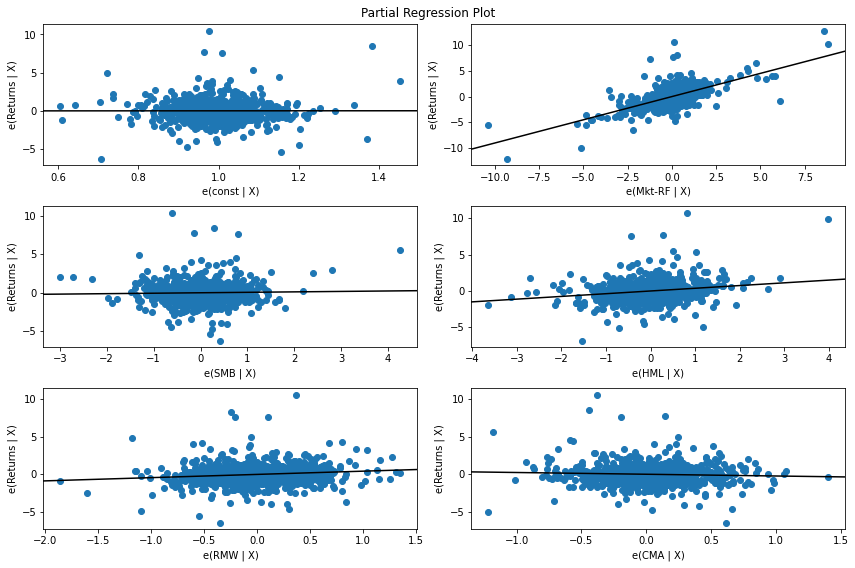

In [ ]:
# Plot Partial Regression Plot:
fig = sm.graphics.plot_partregress_grid(model_results, fig = plt.figure(figsize=(12,8)))
plt.show()

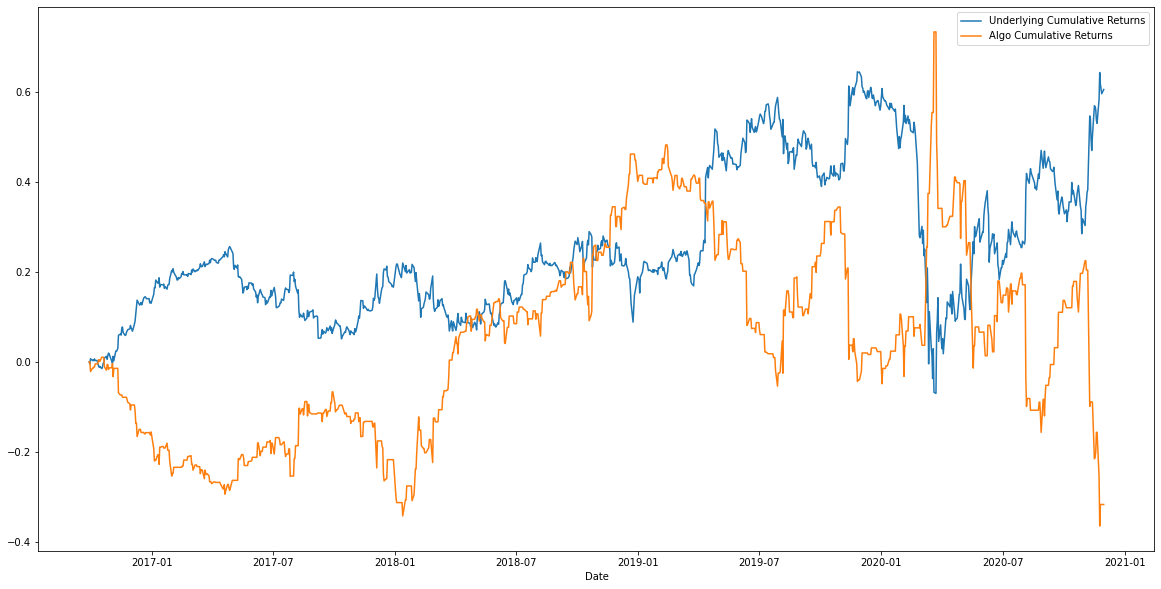

In [ ]:
# Plot Cumulative Returns:
underlying_returns(signals_df).plot(figsize=(20,10))

## SPY


In [ ]:
# Read-in SPY dataframe:
ticker="SPY"
stock=choose_stock(ticker)
stock.head()

,Close,Returns
Date,,
2000-01-03,145.44,NaN
2000-01-04,139.75,-3.912266
2000-01-05,140.00,0.178891
2000-01-06,137.75,-1.607143
2000-01-07,145.75,5.807623


In [ ]:
# Concatenate Fama-French DataFrame with Stock DataFrame:
combined_df = pd.concat([factors, stock], axis='columns', join='inner')

# Drop nulls:
combined_df = combined_df.dropna()
combined_df = combined_df.drop('RF', axis=1)

# Preview DataFrame
combined_df.head()

,Mkt-RF,SMB,HML,RMW,CMA,Close,Returns
Date,,,,,,,
2000-01-04,-4.06,0.35,2.14,0.43,1.46,139.75,-3.912266
2000-01-05,-0.09,0.31,0.29,0.42,1.01,140.00,0.178891
2000-01-06,-0.73,-0.03,1.27,0.65,1.19,137.75,-1.607143
2000-01-07,3.21,-0.95,-1.43,-0.87,-0.95,145.75,5.807623
2000-01-10,1.76,0.50,-1.52,-1.97,-0.07,146.25,0.343053


In [ ]:
# Define X and y variables:
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)
y = combined_df.loc[:, 'Returns']

In [ ]:
# Split into Training/Testing Data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
close_test=combined_df["Close"][split:]
close_test

Date
2016-09-26    214.24
2016-09-27    215.57
2016-09-28    216.64
2016-09-29    214.68
2016-09-30    216.30
               ...  
2020-11-23    357.46
2020-11-24    363.22
2020-11-25    362.66
2020-11-27    363.67
2020-11-30    362.06
Name: Close, Length: 1053, dtype: float64

In [ ]:
# Import Linear Regression Model from SKLearn:
from sklearn.linear_model import LinearRegression

# Create, train, and predict model:
lin_reg_model = LinearRegression(fit_intercept=True)
lin_reg_model = lin_reg_model.fit(X_train, y_train)
predictions = lin_reg_model.predict(X_test)

In [ ]:
# Convert y_test to a dataframe:
y_test = y_test.to_frame()

In [ ]:
signals_df = y_test.copy()

# Add "predictions" to dataframe:
y_test['Predictions'] = predictions
y_test["Close"]=close_test

# Add "Buy Signal" column based on whether day's predictions were greater than the day's actual returns:
y_test['Buy Signal'] = np.where(y_test['Predictions'] > y_test['Returns'], 1.0,0.0)

# Drop nulls:
y_test=y_test.dropna()

y_test.head()

,Returns,Predictions,Close,Buy Signal
Date,,,,
2016-09-26,-0.810223,-0.859748,214.24,0.0
2016-09-27,0.620799,0.631753,215.57,1.0
2016-09-28,0.496358,0.491974,216.64,0.0
2016-09-29,-0.904727,-0.862059,214.68,1.0
2016-09-30,0.754612,0.809606,216.30,1.0


In [ ]:
# Generate signals Dataframe using generate signals function
signals_df=generate_signals(y_test)

In [ ]:
# Generate Metrics for Algorithm:
algo_evaluation(signals_df)

,Backtest
Annual Return,0.38742
Cumulative Returns,0.4516
Annual Volatility,0.766237
Sharpe Ratio,0.505614
Sortino Ratio,0.736929


In [ ]:
# Generate Metrics for Algorithm vs Buy-and-Hold Strategy:
algo_vs_underlying(signals_df)

,Algo,Underlying
Annual Return,0.38742,0.142886
Cumulative Returns,0.4516,0.671252
Annual Volatility,0.766237,0.197921
Sharpe Ratio,0.505614,0.721934
Sortino Ratio,0.736929,0.986703


In [ ]:
# Generate Metrics dataframe:
trade_evaluation_df=trade_evaluation(signals_df)
trade_evaluation_df

,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,,2016-09-28,0,0,216.64,0,102140.0,102140.0
1,2016-09-29,2016-10-03,2000,214.68,215.78,102140,104340.0,2200.0
2,2016-10-04,2016-10-06,2000,214.68,215.78,104340,106540.0,2200.0
3,2016-10-11,2016-10-18,2000,213.43,213.71,106540,107100.0,560.0
4,2016-10-21,2016-10-25,2000,213.98,214.17,107100,107480.0,380.0
...,...,...,...,...,...,...,...,...
281,2020-10-29,2020-10-30,2000,329.98,326.54,100720,93840.0,-6880.0
282,2020-11-02,2020-11-09,2000,330.2,354.56,93840,142560.0,48720.0
283,2020-11-11,2020-11-13,2000,356.67,358.10,142560,145420.0,2860.0
284,2020-11-17,2020-11-20,2000,360.62,355.33,145420,134840.0,-10580.0


In [ ]:
# Set X and y variables:
y = combined_df.loc[:, 'Returns']
X = combined_df.drop('Returns', axis=1)
X = X.drop('Close',axis=1)

# Add "Constant" column of "1s" to DataFrame to act as an intercept, using StatsModels:
X = sm.add_constant(X)

# Split into Training/Testing data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Run Ordinary Least Squares (OLS )Model:
model = sm.OLS(y_test, X_test)
model_results = model.fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 3.125e+04
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        02:05:13   Log-Likelihood:                 913.62
No. Observations:                1053   AIC:                            -1815.
Df Residuals:                    1047   BIC:                            -1785.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0050      0.003     -1.593      0.1

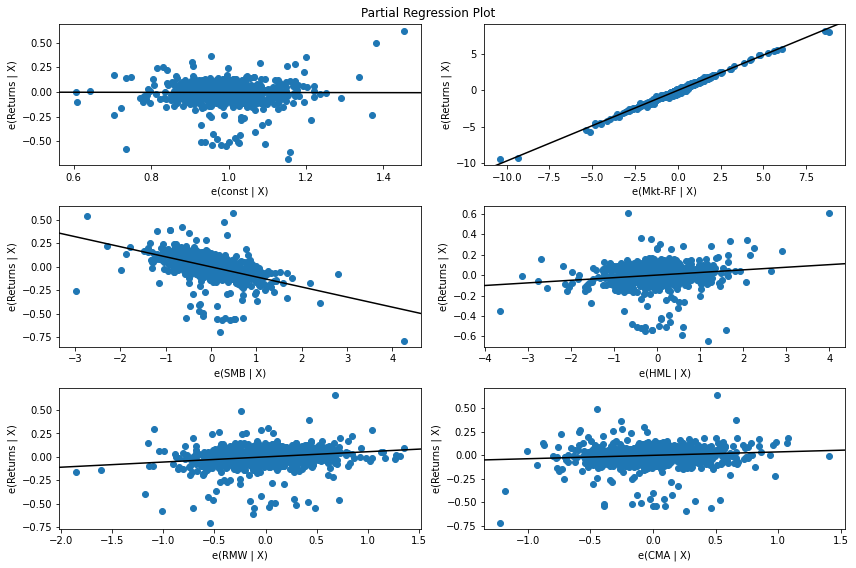

In [ ]:
# Plot Partial Regression Plot:
fig = sm.graphics.plot_partregress_grid(model_results, fig = plt.figure(figsize=(12,8)))
plt.show()

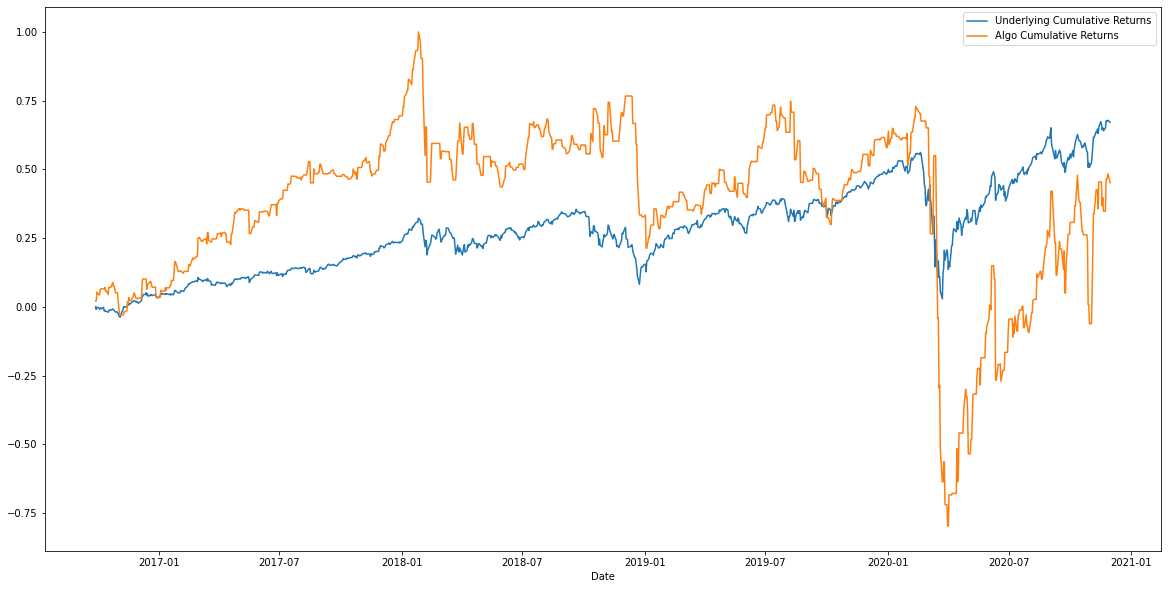

In [ ]:
# Plot Cumulative Returns:
underlying_returns(signals_df).plot(figsize=(20,10))